In [ ]:
# --- Install dependencies (Colab) ---
import sys, subprocess, pkg_resources

def pip_install(args):
    print("Installing:", ' '.join(args))
    return subprocess.check_call([sys.executable, "-m", "pip", "install", *args])

try:
    import torch
except Exception:
    pip_install(["torch", "torchvision", "torchaudio", "--index-url", "https://download.pytorch.org/whl/cpu"])
    import torch

torch_v = torch.__version__.split('+')[0]
print("Torch:", torch.__version__)

# Install PyG wheels compatible with the Torch version
wurl = f"https://data.pyg.org/whl/torch-{torch_v}+cpu.html"
to_install = [
    "torch_geometric",
    "torch_scatter",
    "torch_sparse",
    "torch_cluster",
]
pip_install([*to_install, "-f", wurl])

pip_install(["scikit-learn", "pandas", "matplotlib", "networkx", "numpy"])

/tmp/ipython-input-2924517861.py:2: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import sys, subprocess, pkg_resources


Torch: 2.8.0+cu126
Installing: torch_geometric torch_scatter torch_sparse torch_cluster -f https://data.pyg.org/whl/torch-2.8.0+cpu.html
Installing: scikit-learn pandas matplotlib networkx numpy


0

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, average_precision_score, precision_recall_curve
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv, SAGEConv

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [ ]:
CSV_PATH = '/content/paysim.csv'
assert os.path.exists(CSV_PATH), f"Not found: {CSV_PATH}"
df = pd.read_csv(CSV_PATH)

need = {'step','type','amount','nameOrig','oldbalanceOrg','newbalanceOrig','nameDest','oldbalanceDest','newbalanceDest','isFraud'}
missing = need - set(df.columns)
assert not missing, f"Missing columns: {missing}"

In [ ]:
SUBSET = 500_000
if len(df) > SUBSET:
    strat_labels = df['isFraud'].values
    _, sub_idx = train_test_split(np.arange(len(df)), test_size=SUBSET, stratify=strat_labels, random_state=42)
    df = df.iloc[sub_idx].reset_index(drop=True)

In [ ]:
fraud_ratio = df['isFraud'].mean()
print(f"Subset size: {len(df)}")
print(f"Fraud ratio in subset: {fraud_ratio:.6f}")


Subset size: 500000
Fraud ratio in subset: 0.001290


In [ ]:
# Add hour (0-23) and day (0-based) features
df['hour'] = df['step'] % 24
df['day'] = df['step'] // 24
df['day_of_month'] = (df['day'] % 31) + 1



In [ ]:
print(df.head())

   step      type     amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0    40   PAYMENT   20390.02   C377321813      522763.20       502373.18   
1   274  CASH_OUT    1072.48   C579448605           0.00            0.00   
2   322   CASH_IN  174418.02  C1989560101     4735344.33      4909762.34   
3   251   PAYMENT   39375.67  C1343256601       29773.67            0.00   
4   153   PAYMENT   25085.05  C1480894164           0.00            0.00   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  hour  \
0   M677101791            0.00            0.00        0               0    16   
1   C555290826        10109.04        11181.52        0               0    10   
2   C249002111       192249.26        17831.24        0               0    10   
3   M467456359            0.00            0.00        0               0    11   
4  M1251866332            0.00            0.00        0               0     9   

   day  day_of_month  
0    1             2  
1   11    

In [ ]:
# ---------- Build graph ----------
accounts = pd.Index(pd.unique(pd.concat([df['nameOrig'], df['nameDest']], ignore_index=True)))
acc2id = {a:i for i,a in enumerate(accounts)}

src = df['nameOrig'].map(acc2id).astype(np.int64).values
dst = df['nameDest'].map(acc2id).astype(np.int64).values
edge_index = torch.from_numpy(np.vstack([src, dst]))

# Edge features
type_ohe = pd.get_dummies(df['type'], prefix='type')
edge_feats = pd.DataFrame({
    'amount': df['amount'].astype(float),
    'step': df['step'].astype(int),
    'deltaOrg': (df['oldbalanceOrg'] - df['newbalanceOrig']).astype(float),
    'deltaDest': (df['newbalanceDest'] - df['oldbalanceDest']).astype(float),
    'flagged': df.get('isFlaggedFraud', 0).astype(int),
})
edge_feats = pd.concat([edge_feats, type_ohe], axis=1)

scaler = StandardScaler()
for c in ['amount','step','deltaOrg','deltaDest']:
    edge_feats[c] = scaler.fit_transform(edge_feats[[c]])

edge_attr = torch.from_numpy(edge_feats.values.astype(np.float32))

# Node features: log degree in and out
num_nodes = len(accounts)
deg_in  = np.bincount(dst, minlength=num_nodes)
deg_out = np.bincount(src, minlength=num_nodes)
node_x = torch.from_numpy(np.vstack([np.log1p(deg_in), np.log1p(deg_out)]).T.astype(np.float32))

edge_label = torch.from_numpy(df['isFraud'].astype(int).values)

In [ ]:
def build_symbolic(df_raw: pd.DataFrame) -> pd.DataFrame:
    sym = pd.DataFrame(index=df_raw.index)

    # Original symbolic rules
    sym['Sym_ZeroAmount'] = (df_raw['amount'] == 0).astype(int)
    sym['Sym_AmountInFraudRange'] = ((df_raw['amount'] >= 63.8) & (df_raw['amount'] <= 10_000_000)).astype(int)
    sym['Sym_ZeroBalanceDestAndAmount'] = (
        (df_raw['newbalanceDest'] == 0) &
        (df_raw['oldbalanceDest'] == 0) &
        (df_raw['amount'] > 0)
    ).astype(int)

    # High amount thresholds
    q95 = df_raw['amount'].quantile(0.95)
    q99 = df_raw['amount'].quantile(0.99)
    sym['Sym_HighAmount'] = (df_raw['amount'] > q95).astype(int)
    sym['Sym_VeryHighAmount'] = (df_raw['amount'] > q99).astype(int)

    # Risky transaction types
    risky = df_raw['type'].isin(['TRANSFER', 'CASH_OUT']).astype(int)
    sym['Sym_RiskyType'] = risky

    # Drain pattern
    sym['Sym_Drain'] = ((df_raw['newbalanceOrig'] == 0) & (df_raw['oldbalanceOrg'] > 0) & risky).astype(int)

    # Large jump in destination balance
    jump = (df_raw['newbalanceDest'] - df_raw['oldbalanceDest'])
    sym['Sym_LargeDestJump'] = (jump > jump.quantile(0.99)).astype(int)

    # Burst of transactions in the same step
    cnt = df_raw['step'].map(df_raw['step'].value_counts())
    sym['Sym_StepBurst'] = (cnt > cnt.quantile(0.99)).astype(int)

    # Time features
    if 'hour' not in df_raw.columns:
        df_raw['hour'] = df_raw['step'] % 24
    if 'day' not in df_raw.columns:
        df_raw['day'] = (df_raw['step'] // 24) % 31  # 0-30

    sym['Sym_NightHour'] = ((df_raw['hour'] >= 0) & (df_raw['hour'] <= 6)).astype(int)
    sym['Sym_WeekendDay'] = df_raw['day'].isin([5, 6]).astype(int)  # adjust if needed

    # Day of month features
    df_raw['day_of_month'] = df_raw['day'] + 1
    sym['Sym_HighFraudDay'] = (df_raw['day_of_month'] == 31).astype(int)
    sym['Sym_LowFraudDay'] = (df_raw['day_of_month'] == 1).astype(int)

    # --- New symbolic features: Duplicate senders & receivers ---
    dup_senders_mask = df_raw['nameOrig'].duplicated(keep=False)
    sym['Sym_DupSender'] = dup_senders_mask.astype(int)

    dup_receivers_mask = df_raw['nameDest'].duplicated(keep=False)
    sym['Sym_DupReceiver'] = dup_receivers_mask.astype(int)

    return sym



In [ ]:
def build_rule_conf(sym_df: pd.DataFrame, device: torch.device):
    rule_conf = torch.zeros(len(sym_df), dtype=torch.float32, device=device)

    # Strong patterns
    hi = (
        (sym_df['Sym_VeryHighAmount'] == 1) |
        (sym_df['Sym_HighAmount'] == 1) |
        (sym_df['Sym_Drain'] == 1) |
        ((sym_df['Sym_RiskyType'] == 1) & (sym_df['Sym_LargeDestJump'] == 1)) |
        (sym_df['Sym_HighFraudDay'] == 1) |
        ((sym_df['Sym_NightHour'] == 1) & (sym_df['Sym_RiskyType'] == 1))
    )

    # Weaker patterns
    hi_zero_amt = (sym_df['Sym_ZeroAmount'] == 1)
    in_fraud_range = (sym_df['Sym_AmountInFraudRange'] == 1)
    zero_bal_dest_and_amt = (sym_df['Sym_ZeroBalanceDestAndAmount'] == 1)
    low_fraud_day = (sym_df['Sym_LowFraudDay'] == 1)

    # New symbolic features: duplicate sender & receiver
    dup_sender = (sym_df['Sym_DupSender'] == 1)
    dup_receiver = (sym_df['Sym_DupReceiver'] == 1)

    # Confidence weights
    val_090 = 0.9
    val_095 = 0.95
    val_060 = 0.6
    val_049 = 0.49
    val_030 = 0.3  # low fraud day weight

    val_dup_sender = 0.4  # moderate weight for duplicate sender
    val_dup_receiver = 0.2  # smaller weight for duplicate receiver

    # Additive scoring
    rule_conf += torch.tensor(val_090, device=device) * torch.tensor(hi.values, dtype=torch.float32, device=device)
    rule_conf += torch.tensor(val_095, device=device) * torch.tensor(hi_zero_amt.values, dtype=torch.float32, device=device)
    rule_conf += torch.tensor(val_060, device=device) * torch.tensor(in_fraud_range.values, dtype=torch.float32, device=device)
    rule_conf += torch.tensor(val_049, device=device) * torch.tensor(zero_bal_dest_and_amt.values, dtype=torch.float32, device=device)
    rule_conf += torch.tensor(val_030, device=device) * torch.tensor(low_fraud_day.values, dtype=torch.float32, device=device)

    rule_conf += torch.tensor(val_dup_sender, device=device) * torch.tensor(dup_sender.values, dtype=torch.float32, device=device)
    rule_conf += torch.tensor(val_dup_receiver, device=device) * torch.tensor(dup_receiver.values, dtype=torch.float32, device=device)

    # Cap at 1.0
    rule_conf = torch.clamp(rule_conf, 0, 1)

    return rule_conf


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sym_df = build_symbolic(df)
edge_sym = torch.from_numpy(sym_df.values.astype(np.float32)).to(device)
rule_conf = build_rule_conf(sym_df, device)


In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

idx = np.arange(len(edge_label))

# Ensure edge_label is on CPU for train_test_split stratify
edge_label_cpu = edge_label.cpu().numpy()

tr, te = train_test_split(idx, test_size=0.2, stratify=edge_label_cpu, random_state=42)
tr, va = train_test_split(tr, test_size=0.2, stratify=edge_label_cpu[tr], random_state=42)

# Create masks on CPU first (matching edge_label device)
train_mask = torch.zeros(len(idx), dtype=torch.bool)
val_mask = torch.zeros(len(idx), dtype=torch.bool)
test_mask = torch.zeros(len(idx), dtype=torch.bool)

train_mask[tr] = True
val_mask[va] = True
test_mask[te] = True

# Move masks to device (GPU/CPU)
train_mask = train_mask.to(device)
val_mask = val_mask.to(device)
test_mask = test_mask.to(device)

# Move edge_label to device to match mask device
edge_label = edge_label.to(device)

pos = int(edge_label[train_mask].sum().item())
neg = int(train_mask.sum().item()) - pos

pos_weight = torch.tensor([neg / max(pos, 1)], device=device)

bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight)




In [ ]:
data = Data(x=node_x, edge_index=edge_index, edge_attr=edge_attr)

In [ ]:
class EdgeGNN_Symbolic(nn.Module):
    def __init__(self, in_node, in_edge, in_sym, conv_type='sage', hid=64, sym_dim=8, heads=4, dropout=0.3):
        super().__init__()
        # Select conv type
        if conv_type == 'gcn':
            self.conv1 = GCNConv(in_node, hid)
            self.conv2 = GCNConv(hid, hid)

        elif conv_type == 'gat':
            self.conv1 = GATConv(in_node, hid // heads, heads=heads)
            self.conv2 = GATConv(hid, hid // heads, heads=heads)

        else:  # default to GraphSAGE
            self.conv1 = SAGEConv(in_node, hid)
            self.conv2 = SAGEConv(hid, hid)

        self.sym_enc = nn.Linear(in_sym, sym_dim)
        self.mlp = nn.Sequential(
            nn.Linear(hid * 2 + in_edge + sym_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
        )

    def forward(self, data, edge_sym):
        x = F.relu(self.conv1(data.x, data.edge_index))
        x = F.relu(self.conv2(x, data.edge_index))
        s, d = data.edge_index
        z = torch.cat([x[s], x[d], data.edge_attr, self.sym_enc(edge_sym)], dim=1)
        return self.mlp(z).squeeze(-1)


sym_model = EdgeGNN_Symbolic(
    in_node=node_x.size(1),
    in_edge=edge_attr.size(1),
    in_sym=edge_sym.size(1),
    conv_type ='gat' ### to change GNN variant change the conv_type
).to(device)




In [ ]:
@torch.no_grad()
def eval_logits(logits, mask, y_true):
    probs = torch.sigmoid(logits).detach().cpu().numpy()
    m = mask.detach().cpu().numpy()
    yt = y_true.detach().cpu().numpy()[m]

    pr_auc = average_precision_score(yt, probs[m])
    prec, rec, thr = precision_recall_curve(yt, probs[m])

    f1 = 2 * prec * rec / (prec + rec + 1e-12)
    bi = f1.argmax()
    threshold = thr[bi - 1] if bi > 0 else 0.5

    yp = (probs[m] >= threshold).astype(int)
    report = classification_report(yt, yp, digits=4)

    return pr_auc, threshold, report


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move everything to same device
data = data.to(device)
edge_sym = edge_sym.to(device)
edge_label = edge_label.to(device)
train_mask = train_mask.to(device)
val_mask = val_mask.to(device)
test_mask = test_mask.to(device)


In [ ]:

EPOCHS = 100
alpha = 0.1  # regularization weight on rule confidence

opt = torch.optim.Adam(sym_model.parameters(), lr=1e-3, weight_decay=1e-4)

for e in range(1, EPOCHS + 1):
    sym_model.train()
    opt.zero_grad()
    logits = sym_model(data, edge_sym)
    ce = bce(logits[train_mask], edge_label[train_mask].float())
    p = torch.sigmoid(logits)
    rl = torch.mean(torch.abs(p[train_mask] - rule_conf[train_mask]))  # soft align
    loss = ce + alpha * rl
    loss.backward()
    nn.utils.clip_grad_norm_(sym_model.parameters(), 1.0)
    opt.step()

    if e == 1 or e % 5 == 0:
        sym_model.eval()
        with torch.no_grad():
            val_logits = sym_model(data, edge_sym)
        pr_auc, thr, _ = eval_logits(val_logits, val_mask, edge_label)
        print(f"[SYM ] Ep{e:02d} loss={loss.item():.4f} (ce={ce.item():.4f}, rl={rl.item():.4f}) | val PR-AUC={pr_auc:.4f}")

[SYM ] Ep01 loss=1.4033 (ce=1.3621, rl=0.4121) | val PR-AUC=0.3500
[SYM ] Ep05 loss=1.2781 (ce=1.2371, rl=0.4106) | val PR-AUC=0.4083
[SYM ] Ep10 loss=1.1767 (ce=1.1349, rl=0.4178) | val PR-AUC=0.4206
[SYM ] Ep15 loss=1.0860 (ce=1.0418, rl=0.4421) | val PR-AUC=0.4249
[SYM ] Ep20 loss=1.0030 (ce=0.9543, rl=0.4870) | val PR-AUC=0.4348
[SYM ] Ep25 loss=0.9262 (ce=0.8718, rl=0.5437) | val PR-AUC=0.4475
[SYM ] Ep30 loss=0.8613 (ce=0.8030, rl=0.5832) | val PR-AUC=0.4669
[SYM ] Ep35 loss=0.8029 (ce=0.7437, rl=0.5920) | val PR-AUC=0.4862
[SYM ] Ep40 loss=0.7510 (ce=0.6896, rl=0.6143) | val PR-AUC=0.5053
[SYM ] Ep45 loss=0.7059 (ce=0.6417, rl=0.6422) | val PR-AUC=0.5184
[SYM ] Ep50 loss=0.6543 (ce=0.5891, rl=0.6522) | val PR-AUC=0.5327
[SYM ] Ep55 loss=0.6193 (ce=0.5518, rl=0.6745) | val PR-AUC=0.5465
[SYM ] Ep60 loss=0.5842 (ce=0.5157, rl=0.6855) | val PR-AUC=0.5599
[SYM ] Ep65 loss=0.5402 (ce=0.4700, rl=0.7015) | val PR-AUC=0.5739
[SYM ] Ep70 loss=0.5080 (ce=0.4363, rl=0.7167) | val PR-AUC=0.

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
# ------------------------------
sym_model.eval()
with torch.no_grad():
    test_logits = sym_model(data, edge_sym)
    probs = torch.sigmoid(test_logits)  # probabilities
    true_labels = edge_label[test_mask].cpu()
    probs_test = probs[test_mask].cpu()

# Get threshold and PR-AUC
pr_auc, thr, _ = eval_logits(test_logits, test_mask, edge_label)

# Convert probabilities to predicted labels using threshold
pred_labels = (probs_test >= thr).int()

# Classification report
rep = classification_report(true_labels, pred_labels, digits=4)
acc = accuracy_score(true_labels, pred_labels)
roc_auc = roc_auc_score(true_labels, probs_test)

# Print results
print(f"\n[SYM ] Test PR-AUC: {pr_auc:.4f} | Threshold: {thr:.4f}")
print(rep)
print(f"Accuracy = {acc:.4f}")
print(f"ROC Curve AUC = {roc_auc:.4f}")


[SYM ] Test PR-AUC: 0.6689 | Threshold: 0.9744
              precision    recall  f1-score   support

           0     0.9994    0.9999    0.9997     99871
           1     0.8846    0.5349    0.6667       129

    accuracy                         0.9993    100000
   macro avg     0.9420    0.7674    0.8332    100000
weighted avg     0.9993    0.9993    0.9992    100000

Accuracy = 0.9993
ROC Curve AUC = 0.9911


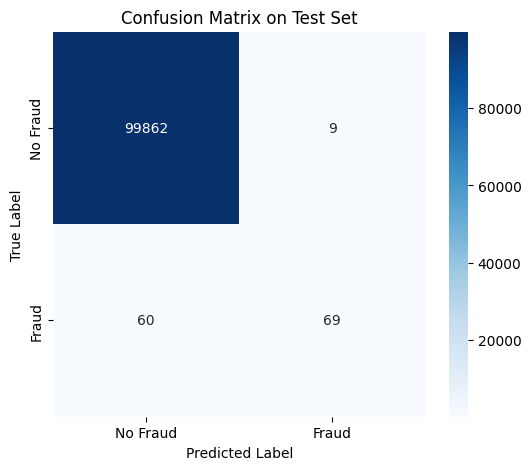

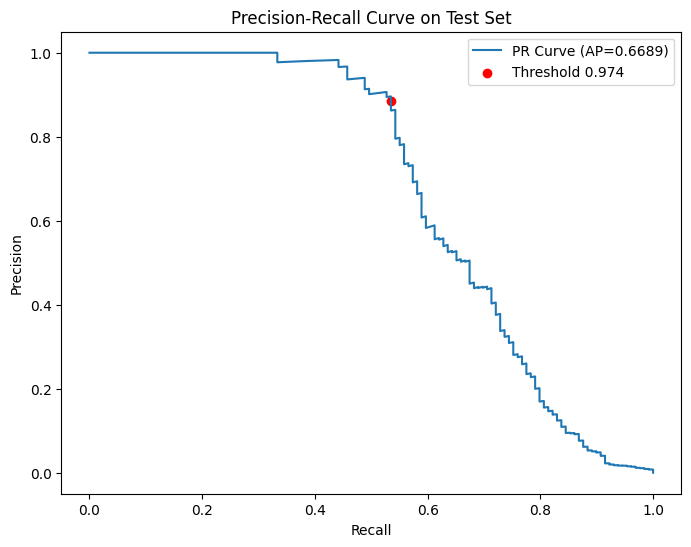

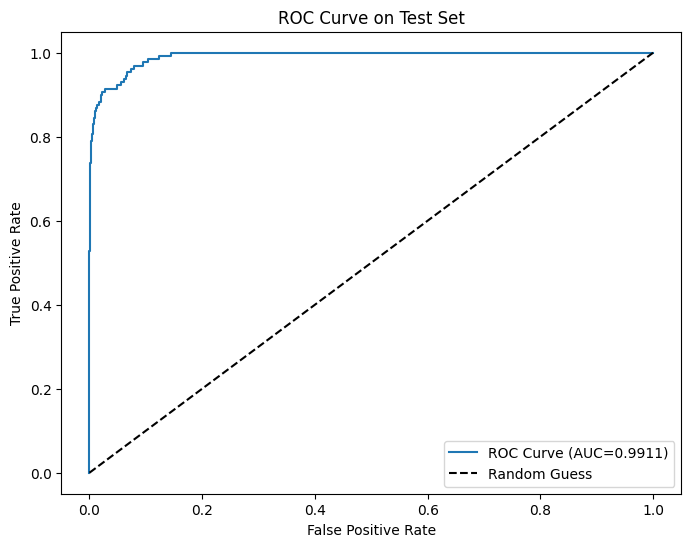

ROC Curve AUC = 0.9911


In [ ]:

from sklearn.metrics import roc_curve, roc_auc_score

probs = torch.sigmoid(test_logits).cpu().numpy()
y_true = edge_label.cpu().numpy()
mask = test_mask.cpu().numpy()

probs_test = probs[mask]
y_true_test = y_true[mask]

y_pred = (probs_test >= thr).astype(int)

# Confusion matrix
cm = confusion_matrix(y_true_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Fraud','Fraud'], yticklabels=['No Fraud','Fraud'])
plt.title('Confusion Matrix on Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('confusion_matrix_paysim.png')  # Save image
plt.show()

# Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_true_test, probs_test)
ap = average_precision_score(y_true_test, probs_test)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, label=f'PR Curve (AP={ap:.4f})')
try:
    idx = (thresholds >= thr).argmax()
    plt.scatter(recall[idx], precision[idx], color='red', label=f'Threshold {thr:.3f}')
except:
    pass
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve on Test Set')
plt.legend()
plt.savefig('precision_recall_curve_paysim.png')  # Save image
plt.show()

fpr, tpr, roc_thresholds = roc_curve(y_true_test, probs_test)
roc_auc = roc_auc_score(y_true_test, probs_test)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC={roc_auc:.4f})')
plt.plot([0,1], [0,1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on Test Set')
plt.legend()
plt.savefig('roc_curve_paysim.png')  # Save ROC curve image
plt.show()
print(f'ROC Curve AUC = {roc_auc:.4f}')

In [ ]:

cm = confusion_matrix(y_true_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")


True Negatives: 99862
False Positives: 9
False Negatives: 60
True Positives: 69


In [ ]:
test_fraud_count = edge_label[test_mask].sum().item()
test_total_count = test_mask.sum().item()
test_nonfraud_count = test_total_count - test_fraud_count

print(f"Test fraud cases: {test_fraud_count}")
print(f"Test non-fraud cases: {test_nonfraud_count}")


Test fraud cases: 129
Test non-fraud cases: 99871


In [ ]:
# Train set counts
train_fraud_count = edge_label[train_mask].sum().item()
train_total_count = train_mask.sum().item()
train_nonfraud_count = train_total_count - train_fraud_count
print(f"Train fraud cases: {train_fraud_count}")
print(f"Train non-fraud cases: {train_nonfraud_count}")

# Test set counts
test_fraud_count = edge_label[test_mask].sum().item()
test_total_count = test_mask.sum().item()
test_nonfraud_count = test_total_count - test_fraud_count
print(f"Test fraud cases: {test_fraud_count}")
print(f"Test non-fraud cases: {test_nonfraud_count}")


Train fraud cases: 413
Train non-fraud cases: 319587
Test fraud cases: 129
Test non-fraud cases: 99871


In [ ]:
# -- Step 1: Extract symbolic rules from edges --

def extract_edge_rules(symbolic_df: pd.DataFrame, y: pd.Series, min_diff=0.1):
    rules = {}
    sym_cols = list(symbolic_df.columns)
    fraud = symbolic_df[y==1]
    normal = symbolic_df[y==0]

    for c in sym_cols:
        f_true = fraud[c].mean() if len(fraud) > 0 else 0
        n_true = normal[c].mean() if len(normal) > 0 else 0
        diff = f_true - n_true
        if diff > min_diff:
            sign = 1
            rules[f"IF {c} THEN Fraud"] = {
                'confidence': float(f_true),
                'support': float((fraud[c]==1).mean() if len(fraud)>0 else 0),
                'lift': float(f_true / (n_true + 1e-8)),
                'sign': sign
            }
        elif diff < -min_diff:
            sign = -1
            rules[f"IF {c} THEN Fraud"] = {
                'confidence': float(f_true),
                'support': float((fraud[c]==1).mean() if len(fraud)>0 else 0),
                'lift': float(f_true / (n_true + 1e-8)),
                'sign': sign
            }
    rules = dict(sorted(rules.items(), key=lambda kv: abs(kv[1]['lift']), reverse=True))
    return rules

rules = extract_edge_rules(sym_df, df['isFraud'])
print("Top 10 symbolic edge rules:")
for i, (r, info) in enumerate(list(rules.items())[:10]):
    print(f"{i+1:02d}. {r} | conf={info['confidence']:.3f}, lift={info['lift']:.2f}")



Top 10 symbolic edge rules:
01. IF Sym_VeryHighAmount THEN Fraud | conf=0.242, lift=24.93
02. IF Sym_NightHour THEN Fraud | conf=0.293, lift=16.25
03. IF Sym_LargeDestJump THEN Fraud | conf=0.112, lift=11.31
04. IF Sym_HighAmount THEN Fraud | conf=0.445, lift=8.99
05. IF Sym_Drain THEN Fraud | conf=0.989, lift=5.32
06. IF Sym_RiskyType THEN Fraud | conf=1.000, lift=2.30
07. IF Sym_ZeroBalanceDestAndAmount THEN Fraud | conf=0.505, lift=1.39


In [ ]:
# -- Step 2: Compute per-edge max rule confidence --

sym_mat = sym_df.values.astype(np.float32)
col_index = {c:i for i,c in enumerate(sym_df.columns)}
rule_list = [(r, info) for r, info in rules.items() if r.startswith('IF ')]

edge_rule_conf = np.zeros(len(sym_df), dtype=np.float32)
for r, info in rule_list:
    feat = r.split()[1]
    j = col_index.get(feat, None)
    if j is None:
        continue
    active = sym_mat[:, j] > 0.5
    edge_rule_conf[active] = np.maximum(edge_rule_conf[active], info['confidence'])

edge_rule_conf = torch.from_numpy(edge_rule_conf).to(device)
print("Computed per-edge rule confidences.")


Computed per-edge rule confidences.


In [ ]:
idx_to_feat = np.array(sym_df.columns)

def explain_edges(indices, top_rules=5):
    sym_model.eval()
    with torch.no_grad():
        logits = sym_model(data, edge_sym)
        probs = torch.sigmoid(logits).detach().cpu().numpy()

    for i in indices:
        feat_vals = sym_mat[i]
        active_feats = idx_to_feat[feat_vals > 0.5]
        active_rules = []
        for r, info in rules.items():
            feat = r.split()[1]
            if feat in active_feats:
                active_rules.append((r, info['confidence']))
        active_rules.sort(key=lambda t: -t[1])

        print(f"\nEdge {i} | True label={int(edge_label[i].item())} | P(fraud)={probs[i]:.3f}")
        print("Active symbolic features:", list(active_feats))
        print("Top triggered symbolic rules:")
        for r, c in active_rules[:top_rules]:
            print(f"  - {r} (conf={c:.3f})")

# Example: explain 3 random test edges
import numpy as np
test_indices = np.random.choice(np.where(test_mask.cpu().numpy())[0], size=3, replace=False)
explain_edges(test_indices)



Edge 402490 | True label=0 | P(fraud)=0.177
Active symbolic features: ['Sym_AmountInFraudRange', 'Sym_ZeroBalanceDestAndAmount']
Top triggered symbolic rules:
  - IF Sym_ZeroBalanceDestAndAmount THEN Fraud (conf=0.505)

Edge 157470 | True label=0 | P(fraud)=0.038
Active symbolic features: ['Sym_AmountInFraudRange', 'Sym_DupReceiver']
Top triggered symbolic rules:

Edge 81839 | True label=0 | P(fraud)=0.295
Active symbolic features: ['Sym_AmountInFraudRange', 'Sym_RiskyType']
Top triggered symbolic rules:
  - IF Sym_RiskyType THEN Fraud (conf=1.000)
